In [17]:
import pandas as pd
import sklearn.model_selection as skm
from ISLP.models import ModelSpec as MS
import warnings
import numpy as np
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib.pyplot import subplots
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('Lending Club.xlsx')
df = df.dropna()

In [ ]:
dummies = pd.get_dummies(df[['Home', 'emp_length']])

y = df['Loan_rate']

# Drop the column with the independent variable (Loan_rate), and columns for which we created dummy variables
X_ = df.drop(['Loan_rate', 'Home', 'emp_length'], axis=1).astype('float64')

# Define the feature set X. Reference group for emp_length is <1 year. Reference group for Home is 'own'.
X = pd.concat([X_, dummies[['emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years',
'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years', 'Home_MORTGAGE', 'Home_RENT']]], axis=1).astype(float)

X.columns

In [6]:
# Split into training and test sets
X_train, X_test , y_train, y_test = skm.train_test_split(X, y, test_size=0.2, random_state=1)

### Ridge

In [12]:
design = MS(X).fit(X)
D = design.fit_transform(X)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

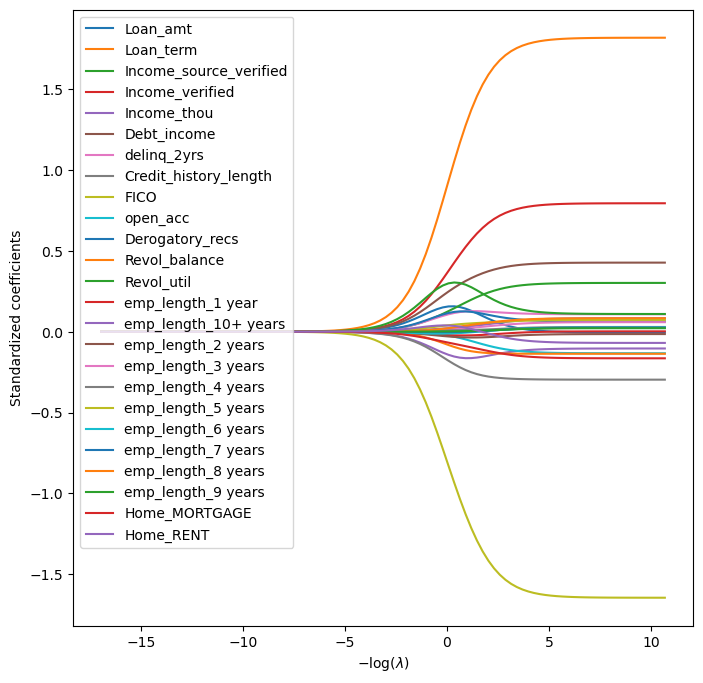

In [19]:
# regularize X 
Xs = X_train - X_train.mean(0)[None,:]
X_scale = X_train.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -4, 100) / y_train.std()
soln_array = skl.ElasticNet.path(Xs, y_train, 
                                 l1_ratio=0., # l1_ratio = 1 for lasso, 0 for ridge, 0-1 for elastic net.
                                 alphas=lambdas)[1]
soln_array.shape

soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'

# Visualize the change in regression coefficients as λ changes
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=10)
ax.set_ylabel('Standardized coefficients', fontsize=10)
ax.legend(loc='upper left', fontsize='10');

The λ chosen by cross-validation is: 0.00809674352012546


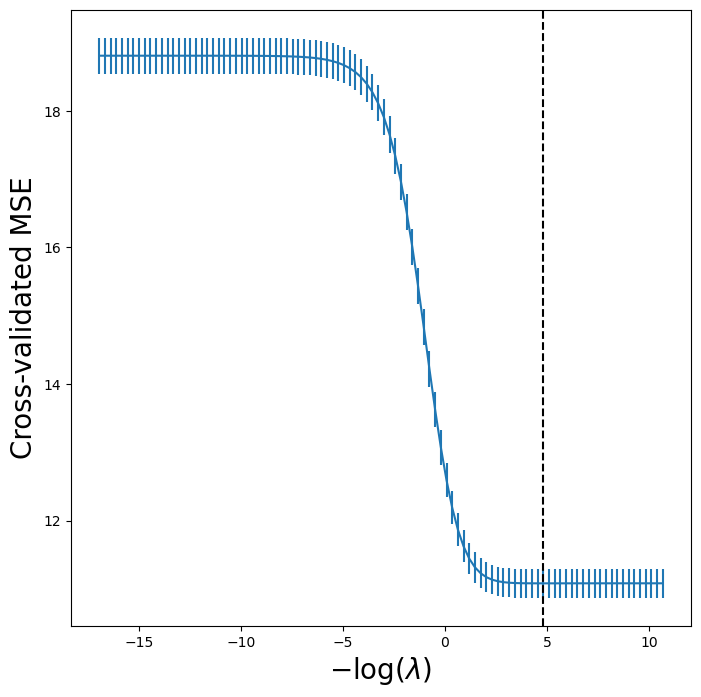

In [20]:
# Cross-validation to find best λ
K=5
kfold = skm.KFold(K, random_state=0, shuffle=True)
ridgeCV = skl.ElasticNetCV(alphas=lambdas, 
                           l1_ratio=0, 
                           cv=kfold)
scaler = StandardScaler(with_mean=True, with_std=True)
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])
pipeCV.fit(Xs, y_train)
tuned_ridge = pipeCV.named_steps['ridge']
ridge_a=tuned_ridge.alpha_

print(f'The λ chosen by cross-validation is: {tuned_ridge.alpha_}')

# graph cross-validaiton MSE
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_ridge.alphas_),
tuned_ridge.mse_path_.mean(1),
yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [21]:
# Refit and find test MSE
ridge = skl.ElasticNet(alpha=ridge_a, 
                           l1_ratio=0)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X_train, y_train)

y_pre=pipe.predict(X_test)

from sklearn.metrics import mean_squared_error

MSE_ridge=mean_squared_error(y_test,y_pre)
print(f'The test error is: {MSE_ridge}')

The test error is: 10.699063670936091


### Lasso

In [22]:
# Cross-validation to find λ
lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1, 
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(Xs, y_train)
tuned_lasso = pipeCV.named_steps['lasso']
lasso_a=tuned_lasso.alpha_

print(f'The λ chosen by cross-validation is: {tuned_lasso.alpha_}')

The λ chosen by cross-validation is: 0.017945016715873736


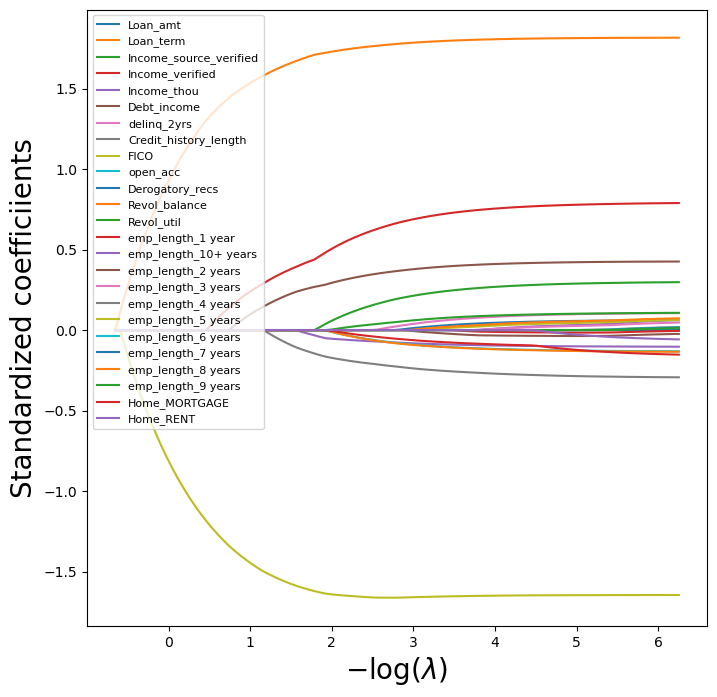

In [24]:
# Visualize the change in regression coefficients as λ changes
lambdas , soln_array = skl.Lasso.path(Xs, y_train, 
                                      l1_ratio=1,
                                      n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas))

path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left', fontsize=8)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

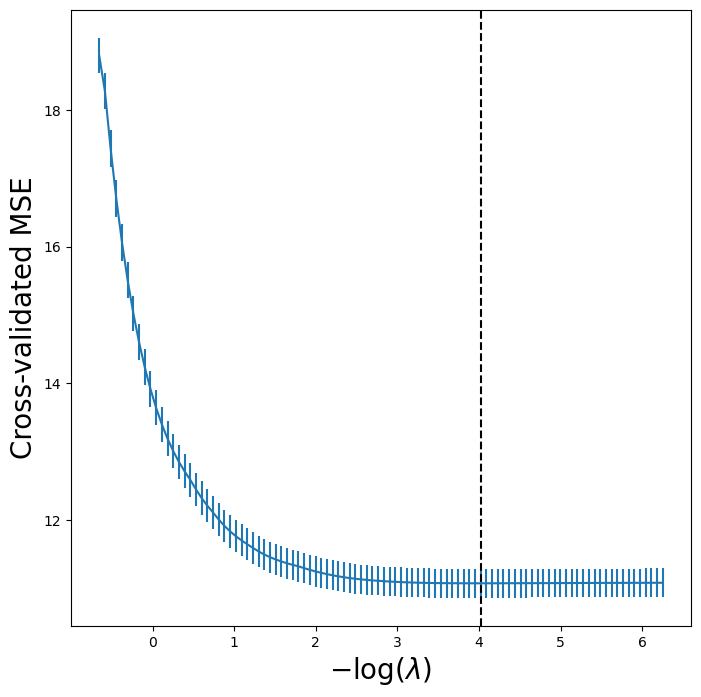

In [26]:
# graph cross-validation MSE
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
tuned_lasso.mse_path_.mean(1),
yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [27]:
# re-fit and print test error
lasso = skl.ElasticNet(alpha=lasso_a, 
                           l1_ratio=1)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])
pipe.fit(X_train, y_train)

y_pre=pipe.predict(X_test)
MSE_lasso=mean_squared_error(y_test,y_pre)
print(f'The test error is: {MSE_lasso}')

The test error is: 10.691531404491021


### Elastic Net

In [29]:
lambda_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

# Cross-validation to find λ and α
elasticnetCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=lambda_range,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('elasticnet', elasticnetCV)])
pipeCV.fit(Xs, y_train)
tuned_elasticnet = pipeCV.named_steps['elasticnet']
elasticnet_a=tuned_elasticnet.alpha_
elasticnet_lambda=tuned_elasticnet.l1_ratio_

print(f'The λ chosen by cross-validation is: {tuned_elasticnet.alpha_}')
print(f'The α chosen by cross-validation is: {tuned_elasticnet.l1_ratio_}')

The λ chosen by cross-validation is: 0.019938907462081934
The α chosen by cross-validation is: 0.9


In [30]:
# re-fit and print test error
elasticnet = skl.ElasticNet(alpha=elasticnet_a, 
                           l1_ratio=elasticnet_lambda)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('elasticnet', elasticnet)])
pipe.fit(X_train, y_train)

y_pre=pipe.predict(X_test)
MSE_elasticnet=mean_squared_error(y_test,y_pre)
print(f'The test error is: {MSE_elasticnet}')

The test error is: 10.691735988570914
